In [36]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import get_cmap
import seaborn as sns
import string
import pickle # save data frame (results) in a .pkl file
import pandas as pd
from datetime import datetime
import os, sys
import re

import grakel as gk


sys.path.insert(0, 'C:/Users/ragna/Documents/Ragnar/Code/MMDGraph')
sys.path.insert(0, 'C:/Users/ragna/Documents/Ragnar/Code/MMDGraph/myKernels')
#from importlib import reload
#reload(readfoldertopanda)
import mmdutils
import importlib
importlib.reload(sys.modules['mmdutils'])
from mmdutils import readfoldertopanda, PlotROCGeneral, plotVaryingBGDEG, findAUC
import MMDforGraphs as mg
importlib.reload(sys.modules['MMDforGraphs'])
from myKernels import RandomWalk as rw
import WL

In [55]:
from importlib import reload  
foo = reload(mg)

n_1 = 20
n_2 = 20
nnode_1 = 50
nnode_2 = 70


bg1 = mg.BinomialGraphs(n_1, nnode_1, k = 2, l = 'degreelabels', fullyConnected = True)
bg2 = mg.BinomialGraphs(n_2, nnode_2, k = 2.25, l = 'degreelabels', fullyConnected = True)
bg1.Generate()
bg2.Generate()
Gs = bg1.Gs + bg2.Gs

In [56]:
importlib.reload(sys.modules['WL'])
wl_graphs = WL.WL()
X, new_labels = wl_graphs.fit_transform(Gs, 4)

In [4]:
def issymmetric(a, rtol=1e-05, atol=1e-08):
    """
    Check if matrix is symmetric
    """
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [9]:
importlib.reload(sys.modules['MMDforGraphs'])
bg1.Generate()
bg2.Generate()
Gs = bg1.Gs + bg2.Gs


# Grakel kernels


graph_list = gk.graph_from_networkx(Gs, node_labels_tag='label')  # Convert to graphs to Grakel format
# kernel = [{"name": "multiscale_laplacian"}]
# K = mg.KernelMatrix(graph_list, kernel, False)   
kernel = [{"name": "weisfeiler_lehman", "n_iter": 4}, {"name": "vertex_histogram"}]
#kernel = [{"name": "WL-OA", "n_iter": 4}]
# kernel = [{"name": "lovasz_theta", "n_samples":20}]
#kernel = [{"name": "core_framework", "min_core": 1}, {"name":"propagation", 't_max':5, 'w':0.1, 'M':"H"}]
# kernel = [{"name": "pyramid_match", "with_labels":True, "d":1, "L":2}] 
#kernel = [{"name":'RW', 'kernel_type':'geometric', 'lamda':0.1, 'with_labels':False, 'p':3}]
#kernel = [{"name":'odd_sth', 'h':3}]
# kernel = [{"name": "propagation", "t_max": 4, "w":1, "M":'TV'}]
init_kernel = gk.GraphKernel(kernel= kernel, normalize=1, n_jobs= 4)
K = init_kernel.fit_transform(graph_list)

# My kernels
# RW kernel
# label list for rw
# label_list = []
# for G in Gs:
#     label_list.append(np.unique(list(nx.get_node_attributes(G, 'label').values())))

# label_list = np.unique(np.concatenate(label_list))
# rw_kernel = rw.RandomWalk(Gs, c = 0.1)
# K = rw_kernel.fit_ARKL(r = 2, label_list = label_list, normalize_adj=True)
#K = rw_kernel.fit_ARKU_plus(r = 6, normalize_adj=False)

print(np.all(K == 0)) 
print(K)


MMD_functions = [mg.MMD_b, mg.MMD_u]

# initialize bootstrap class, we only want this to be initalized once so that numba njit
# only gets compiled once (at first call)
kernel_hypothesis = mg.BoostrapMethods(MMD_functions)
function_arguments=[dict(n = bg1.n, m = bg2.n ), dict(n = bg1.n, m = bg2.n )]
kernel_hypothesis.Bootstrap(K, function_arguments, B = 1000)


# Run power
threshold = np.quantile(kernel_hypothesis.boot_test_statistic['MMD_u'], 1-0.5)
print(f'threshold {threshold}')
ratio, power, V = mg.power_ratio(K, kernel_hypothesis.sample_test_statistic['MMD_u'], n_1*threshold, n_1)
print(f'V {V}')
print(f'ratio {ratio}')
print(f'power {power}')
print(f'p_value {kernel_hypothesis.p_values}')
print(f"MMD_u {kernel_hypothesis.sample_test_statistic['MMD_u']}")

False
[[1.         0.65465759 0.67816095 ... 0.59818902 0.69059201 0.65387778]
 [0.65465759 1.         0.59358957 ... 0.67599099 0.60823238 0.66602959]
 [0.67816095 0.59358957 1.         ... 0.52041927 0.73442417 0.58179246]
 ...
 [0.59818902 0.67599099 0.52041927 ... 1.         0.5435901  0.65167855]
 [0.69059201 0.60823238 0.73442417 ... 0.5435901  1.         0.61424548]
 [0.65387778 0.66602959 0.58179246 ... 0.65167855 0.61424548 1.        ]]
threshold -0.0011769405148253087
V 3.2969134132342215
ratio 0.0012063278482694817
power 0.5004812550659778
p_value {'MMD_b': 0.326, 'MMD_u': 0.326}
MMD_u 0.0010134377656922933


<AxesSubplot:>

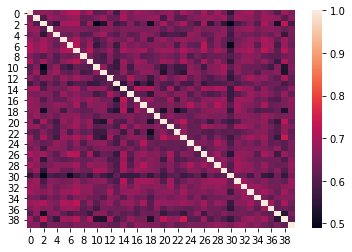

In [10]:
sns.heatmap(K)